In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns

import os

from copy import deepcopy

import tqdm

import pickle


from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix

pd.options.display.max_rows = 1000

In [2]:
outdir_abrupt = './output/synthetic/univariate/abrupt_mixture'
if not os.path.exists(outdir_abrupt):
    os.makedirs(outdir_abrupt)
    
outdir_gradual = './output/synthetic/univariate/gradual_mixture'
if not os.path.exists(outdir_gradual):
    os.makedirs(outdir_gradual)

In [3]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [4]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[t]/self.weights_.shape[0]
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[t])*self.weights_ + self.r[t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            
            # E-step for mean and covariance
            m = (1-self.r[t])*m + self.r[t]*gamma[i]*x
            cov = (1-self.r[t])*cov + self.r[t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step for mean and covariance
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        
        self.means_ = np.vstack(means)
        self.covariances_ = np.vstack(covariances)
        self.means_bar = np.vstack(means_bar)
        self.covariances_bar = np.vstack(covariances_bar)

        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [5]:
def compute_tau(X, theta):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [6]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0)
    s2 = X.T.dot(Z).ravel()
    s3 = (X**2).T.dot(Z).ravel()
    
    return s1, s2, s3

In [7]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = np.sqrt(s.s3 / (s.s1 + eps) - mu**2)
    return pi, mu, sigma

In [8]:
class SuffStat:
    def __init__(self):
        pass

In [9]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.random(K)
        self.s2 = np.random.random(K)
        self.s3 = np.random.random(K)

In [10]:
def sra(X, theta0, rho, gamma, start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    
    theta_est = np.zeros((N, 3*K+1))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(len(theta0.pi), 1)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        s2_indiv_new = X[ind_n, :] * tau_indiv_new
        s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new

        if ( np.any(np.isnan(tau_indiv_new))  | ((np.linalg.norm(s2_indiv_new - s.s2) >= gamma) & (n >= start)) ):
            theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
                
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))

    return theta_est

In [11]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [12]:
def generate_data_abrupt_single(N, 
                                pi=np.array([1.0]), 
                                mu1=np.array([0.5]), 
                                mu2=np.array([1.0]), 
                                sigma=np.array([1.0]), 
                                alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_latter = generate_data(N, pi, mu2, sigma)
    X[N:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    
    
    return X

In [13]:
def generate_data_abrupt_mixture(N, 
                                 pi=np.array([0.5, 0.5]),
                                 mu1=np.array([0.5, -0.5]),
                                 mu2=np.array([1.0, -1.0]),
                                 sigma=np.array([0.1, 0.1]),
                                 alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_latter = generate_data(N, pi, mu2, sigma)
    X[N:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    

    return X

In [14]:
def generate_data_gradual_single(N, 
                                 pi=np.array([1.0]), 
                                 mu1=np.array([0.5]), 
                                 mu2=np.array([1.0]), 
                                 sigma=np.array([1.0]), 
                                 alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
    X[N:(N+300), 0] = Xj_trans
    Xj_latter = generate_data(N-300, pi, mu2, sigma)
    X[N+300:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    
    
    return X

In [15]:
def generate_data_gradual_mixture(N, 
                                  pi=np.array([0.5, 0.5]),
                                  mu1=np.array([0.5, -0.5]),
                                  mu2=np.array([1.0, -1.0]),
                                  sigma = np.array([0.1, 0.1]),
                                  alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
    X[N:(N+300), 0] = Xj_trans
    Xj_latter = generate_data(N-300, pi, mu2, sigma)
    X[N+300:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    

    return X

In [16]:
from matplotlib import gridspec
def create_subtitle(fig: plt.Figure, grid: gridspec.SubplotSpec, title: str):
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [17]:
N = 10000

In [18]:
Nsim = 1

In [19]:
pi = np.array([0.2, 0.8])
pi0 = pi.copy()

In [20]:
mean1 = 0.5
mu1 = np.array([mean1, -mean1])

mean2 = 1.0
mu2 = np.array([mean2, -mean2])

In [21]:
sigma = np.array([0.1, 0.1])
sigma0 = np.array([0.2, 0.2])

In [22]:
seed0 = 1

In [23]:
mu0 = [0.1, -0.1]

In [24]:
theta = Theta(pi, mu1, sigma)
theta0 = Theta(pi0, mu0, sigma0)

In [25]:
seed = seed0
np.random.seed(seed)
X = np.zeros((2*N, 1))
Xj_former = generate_data(N, pi, mu1, sigma)
X[:N, 0] = Xj_former.ravel()
Xj_latter = generate_data(N, pi, mu2, sigma)
X[N:, 0] = Xj_latter.ravel()

idxes_ol = np.random.choice(np.arange(N), int(0.01*N))
X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)

In [26]:
with open(os.path.join(outdir_abrupt, 'results_optrho_df.pkl'), 'rb') as f:
    results_optrho_df_abrupt = pickle.load(f)
    
with open(os.path.join(outdir_gradual, 'results_optrho_df.pkl'), 'rb') as f:
    results_optrho_df_gradual = pickle.load(f)

In [27]:
results_best_abrupt = results_optrho_df_abrupt.loc[
    ((results_optrho_df_abrupt['gamma'] == 1) & (results_optrho_df_abrupt['ratio'] == 0.05) & (results_optrho_df_abrupt['M'] == 5.0) ) | 
    ((results_optrho_df_abrupt['gamma'] == 3) & (results_optrho_df_abrupt['ratio'] == 0.1) & (results_optrho_df_abrupt['M'] == 5.0) ) |
    ((results_optrho_df_abrupt['gamma'] == 5) & (results_optrho_df_abrupt['ratio'] == 0.5) & (results_optrho_df_abrupt['M'] == 5.0) ) | 
    ((results_optrho_df_abrupt['gamma'] == 10) & (results_optrho_df_abrupt['ratio'] == 0.5) & (results_optrho_df_abrupt['M'] == 10.0) ) |
    ((results_optrho_df_abrupt['gamma'] == 15) & (results_optrho_df_abrupt['ratio'] == 0.5) & (results_optrho_df_abrupt['M'] == 10.0) ) 
]

In [28]:
results_best_gradual = results_optrho_df_gradual.loc[
    ((results_optrho_df_gradual['gamma'] == 1) & (results_optrho_df_gradual['ratio'] == 0.05) & (results_optrho_df_gradual['M'] == 5.0) ) | 
    ((results_optrho_df_gradual['gamma'] == 3) & (results_optrho_df_gradual['ratio'] == 0.1) & (results_optrho_df_gradual['M'] == 5.0) ) |
    ((results_optrho_df_gradual['gamma'] == 5) & (results_optrho_df_gradual['ratio'] == 0.5) & (results_optrho_df_gradual['M'] == 5.0) ) | 
    ((results_optrho_df_gradual['gamma'] == 10) & (results_optrho_df_gradual['ratio'] == 0.5) & (results_optrho_df_gradual['M'] == 10.0) ) |
    ((results_optrho_df_gradual['gamma'] == 15) & (results_optrho_df_gradual['ratio'] == 0.5) & (results_optrho_df_gradual['M'] == 10.0) ) 
]

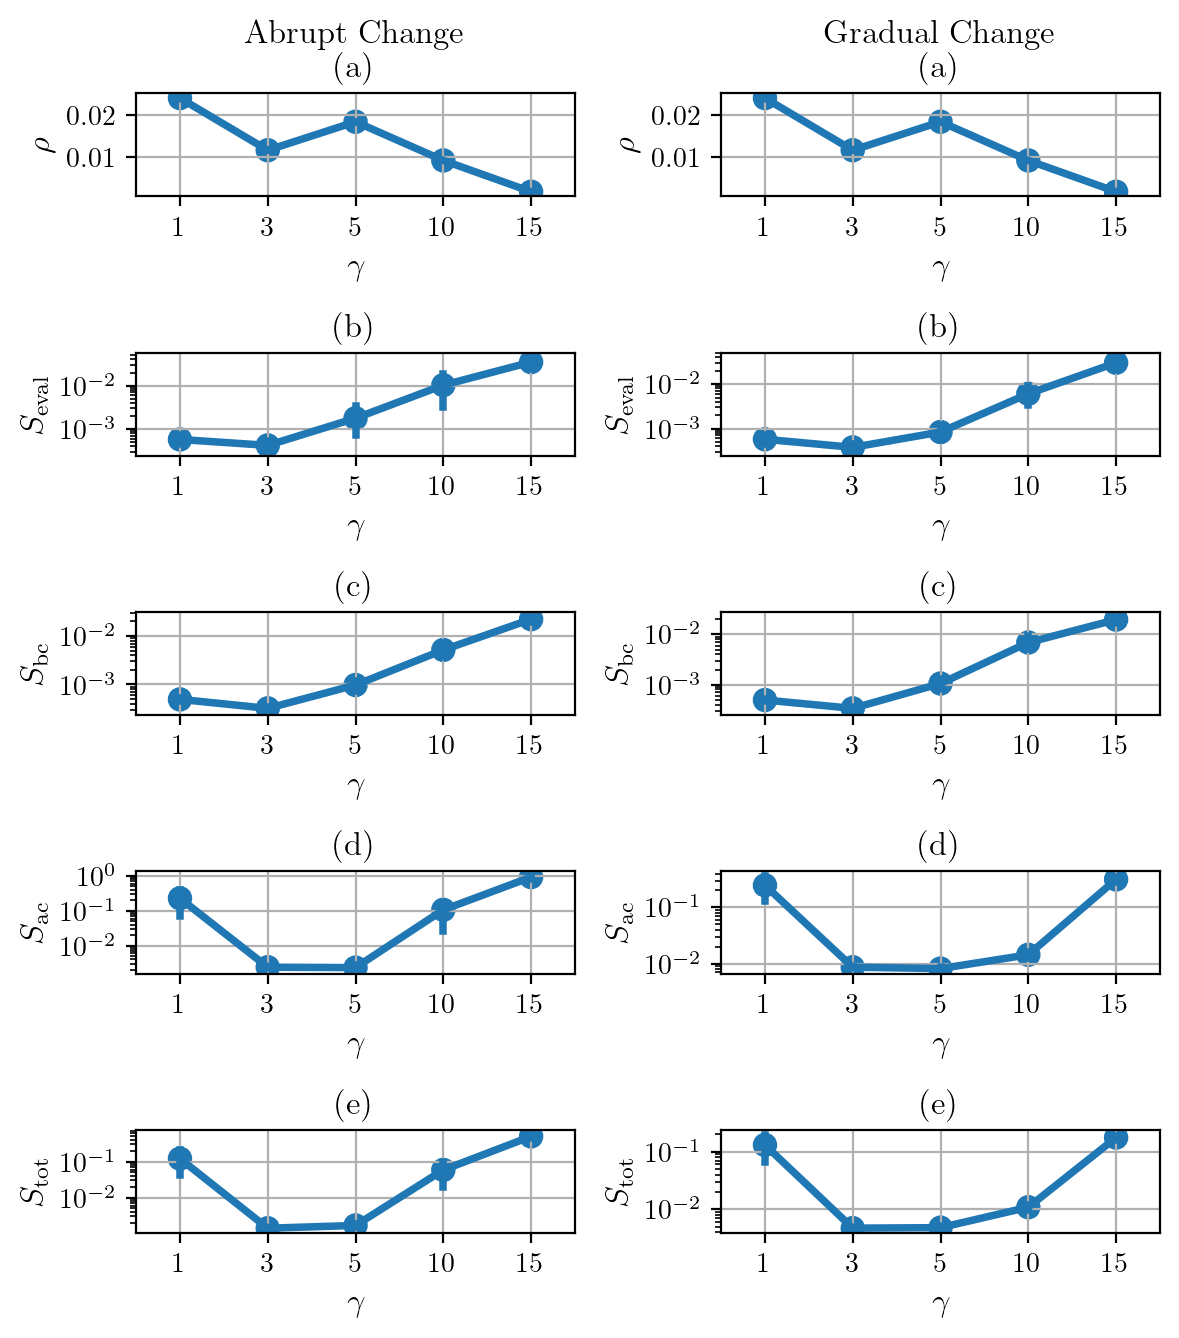

In [29]:
fig, axes = plt.subplots(5, 2, sharex=True, figsize=(6, 7), dpi=200)

sns.pointplot(data=results_best_abrupt, x='gamma', y='rho', ax=axes[0, 0])
sns.pointplot(data=results_best_abrupt, x='gamma', y='pc', ax=axes[1, 0])
sns.pointplot(data=results_best_abrupt, x='gamma', y='former', ax=axes[2, 0])
sns.pointplot(data=results_best_abrupt, x='gamma', y='latter', ax=axes[3, 0])
sns.pointplot(data=results_best_abrupt, x='gamma', y='overall', ax=axes[4, 0])

axes[0, 0].set_title('(a)', fontsize=12)
axes[0, 0].set_xlabel(r'$\gamma$', fontsize=12)
axes[0, 0].set_ylabel(r'$\rho$', fontsize=12)
axes[0, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0, 0].grid()

axes[1, 0].set_title('(b)', fontsize=12)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel(r'$\gamma$', fontsize=12)
axes[1, 0].set_ylabel(r'$S_{\mathrm{eval}}$', fontsize=12)
axes[1, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1, 0].grid()

axes[2, 0].set_title('(c)', fontsize=12)
axes[2, 0].set_yscale('log')
axes[2, 0].set_xlabel(r'$\gamma$', fontsize=12)
axes[2, 0].set_ylabel(r'$S_{\mathrm{bc}}$', fontsize=12)
axes[2, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[2, 0].grid()

axes[3, 0].set_title('(d)', fontsize=12)
axes[3, 0].set_yscale('log')
axes[3, 0].set_xlabel(r'$\gamma$', fontsize=12)
axes[3, 0].set_ylabel(r'$S_{\mathrm{ac}}$', fontsize=12)
axes[3, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[3, 0].grid()

axes[4, 0].set_title('(e)', fontsize=12)
axes[4, 0].set_yscale('log')
axes[4, 0].set_xlabel(r'$\gamma$', fontsize=12)
axes[4, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[4, 0].set_ylabel(r'$S_{\mathrm{tot}}$', fontsize=12)


plt.rc('font', family='serif')
axes[4, 0].set_xticklabels([1, 3, 5, 10, 15])

axes[4, 0].grid()


plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)

sns.pointplot(data=results_best_gradual, x='gamma', y='rho', ax=axes[0, 1])
sns.pointplot(data=results_best_gradual, x='gamma', y='pc', ax=axes[1, 1])
sns.pointplot(data=results_best_gradual, x='gamma', y='former', ax=axes[2, 1])
sns.pointplot(data=results_best_gradual, x='gamma', y='latter', ax=axes[3, 1])
sns.pointplot(data=results_best_gradual, x='gamma', y='overall', ax=axes[4, 1])

axes[0, 1].set_title('(a)', fontsize=12)
axes[0, 1].set_xlabel(r'$\gamma$', fontsize=12)
axes[0, 1].set_ylabel(r'$\rho$', fontsize=12)
axes[0, 1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0, 1].grid()

axes[1, 1].set_title('(b)', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel(r'$\gamma$', fontsize=12)
axes[1, 1].set_ylabel(r'$S_{\mathrm{eval}}$', fontsize=12)
axes[1, 1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1, 1].grid()

axes[2, 1].set_title('(c)', fontsize=12)
axes[2, 1].set_yscale('log')
axes[2, 1].set_xlabel(r'$\gamma$', fontsize=12)
axes[2, 1].set_ylabel(r'$S_{\mathrm{bc}}$', fontsize=12)
axes[2, 1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[2, 1].grid()

axes[3, 1].set_title('(d)', fontsize=12)
axes[3, 1].set_yscale('log')
axes[3, 1].set_xlabel(r'$\gamma$', fontsize=12)
axes[3, 1].set_ylabel(r'$S_{\mathrm{ac}}$', fontsize=12)
axes[3, 1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[3, 1].grid()

axes[4, 1].set_title('(e)', fontsize=12)
axes[4, 1].set_yscale('log')
axes[4, 1].set_xlabel(r'$\gamma$', fontsize=12)
axes[4, 1].set_ylabel(r'$S_{\mathrm{tot}}$', fontsize=12)
axes[4, 1].xaxis.set_tick_params(which='both', labelbottom=True)

plt.rc('font', family='serif')
axes[4, 1].set_xticklabels([1, 3, 5, 10, 15])

axes[4, 1].grid()

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)

grid = plt.GridSpec(5, 2)
create_subtitle(fig, grid[0, 0], 'Abrupt Change')
create_subtitle(fig, grid[0, 1], 'Gradual Change')

plt.tight_layout()
plt.savefig(os.path.join('./output', 'gamma_rho_tradeoff.pdf'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join('./output', 'gamma_rho_tradeoff.eps'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join('./output', 'gamma_rho_tradeoff.png'), dpi=200, bbox_inches='tight')